# Generate standard comparison metrics

These are a set of standard kinematics for comparing models and data.

- Mean energy binned along;
    * Radius from shower axis
    * layer
- Number of cells binned along visible cell energy
- Number of showers binned along
    * center of gravity in x
    * center of gravity in y (detector coords)
    * center of gravity in z (detector coords)
    * number of hits
    * energy sum

Lining up these distributions with geant 4 shows good simulation behaviour.

## Start with imports and configs


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from pointcloud.config_varients.wish import Configs
from pointcloud.config_varients.wish_maxwell import Configs as MaxwellConfigs

from pointcloud.evaluation.bin_standard_metrics import BinnedData, get_path

configs = Configs()


/home/henry/Programs/miniconda3/envs/caloclouds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/henry/Programs/miniconda3/envs/caloclouds/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Histogramming

BinnedData is a class that takes sets of points and accumulates them for each of the binnings we are intrested in.
This class, and related uitilites are in `pointclouds/evaluation/bin_standard_metrics.py`.
We have preped and generated data in this class using `scripts/create_standard_metrics.py`.



## Data as BinnedData

For Geant 4, the accumulator and each of the models, load the generate binned data

Geant 4 is our ground truth, so it gets special treatment.

In [2]:

g4_name = "Geant 4"

def get_path_or_ref(configs, name):
    """
    Get a path to the binned data from the logdir in the configs,
    or if not found, check the reference folder.
    """
    ref_dir = "standard_metrics_ref"
    try:
        save_path = get_path(configs, name)
    except FileNotFoundError:
        save_path = ""
    if not os.path.exists(save_path):
        print(f"Didn't find binned data for {name} in {save_path}")
        ref_path = os.path.join(ref_dir, name.replace(" ", "_") + ".npz")
        print(f"Checking for stored reference in {ref_dir}")
        if os.path.exists(ref_path):
            print(f"Found stored reference")
            save_path = ref_path
    return save_path
    
g4_save_path = get_path_or_ref(configs, g4_name)
if not g4_save_path:
    print(f"Can't load g4 bins, recreate with create_standard_metrics.py or this doesn't really work...")
    
binned_g4 = BinnedData.load(g4_save_path)
        

In [3]:
to_compare = {}

# Name all the models that we might have binned data for
model_names = ["CaloClouds3"]
model_names += [f"Wish-poly{poly_degree}" for poly_degree in range(1, 4)]

for model_name in model_names:
    save_path = get_path_or_ref(configs, model_name)
    if not save_path:
        print(f"Can't load {model_name}, recreate with create_standard_metrics.py if required")
        continue
    binned = BinnedData.load(save_path)
    to_compare[model_name] = binned
        

For only some of the distributions, we can also get data from the StatsAccumulator to compare;

In [4]:
acc_name = "Geant 4 Accumulator"
acc_save_path = get_path_or_ref(configs, acc_name)
    
if acc_save_path:
    binned_acc = BinnedData.load(acc_save_path)
else:
    print(f"Can't load accumulator bins, recreate with create_standard_metrics.py if required")
    binned_acc = None
        

## Plotting

Now the samples have been generated, we can focus on histogramming them.
This may require some manual adjustment to cater for the ranges in which there are significant number of counts.

/tmp/ipykernel_19294/46141795.py:78: RuntimeWarning: divide by zero encountered in divide
  ratio = model_weights/weights
/tmp/ipykernel_19294/46141795.py:78: RuntimeWarning: invalid value encountered in divide
  ratio = model_weights/weights


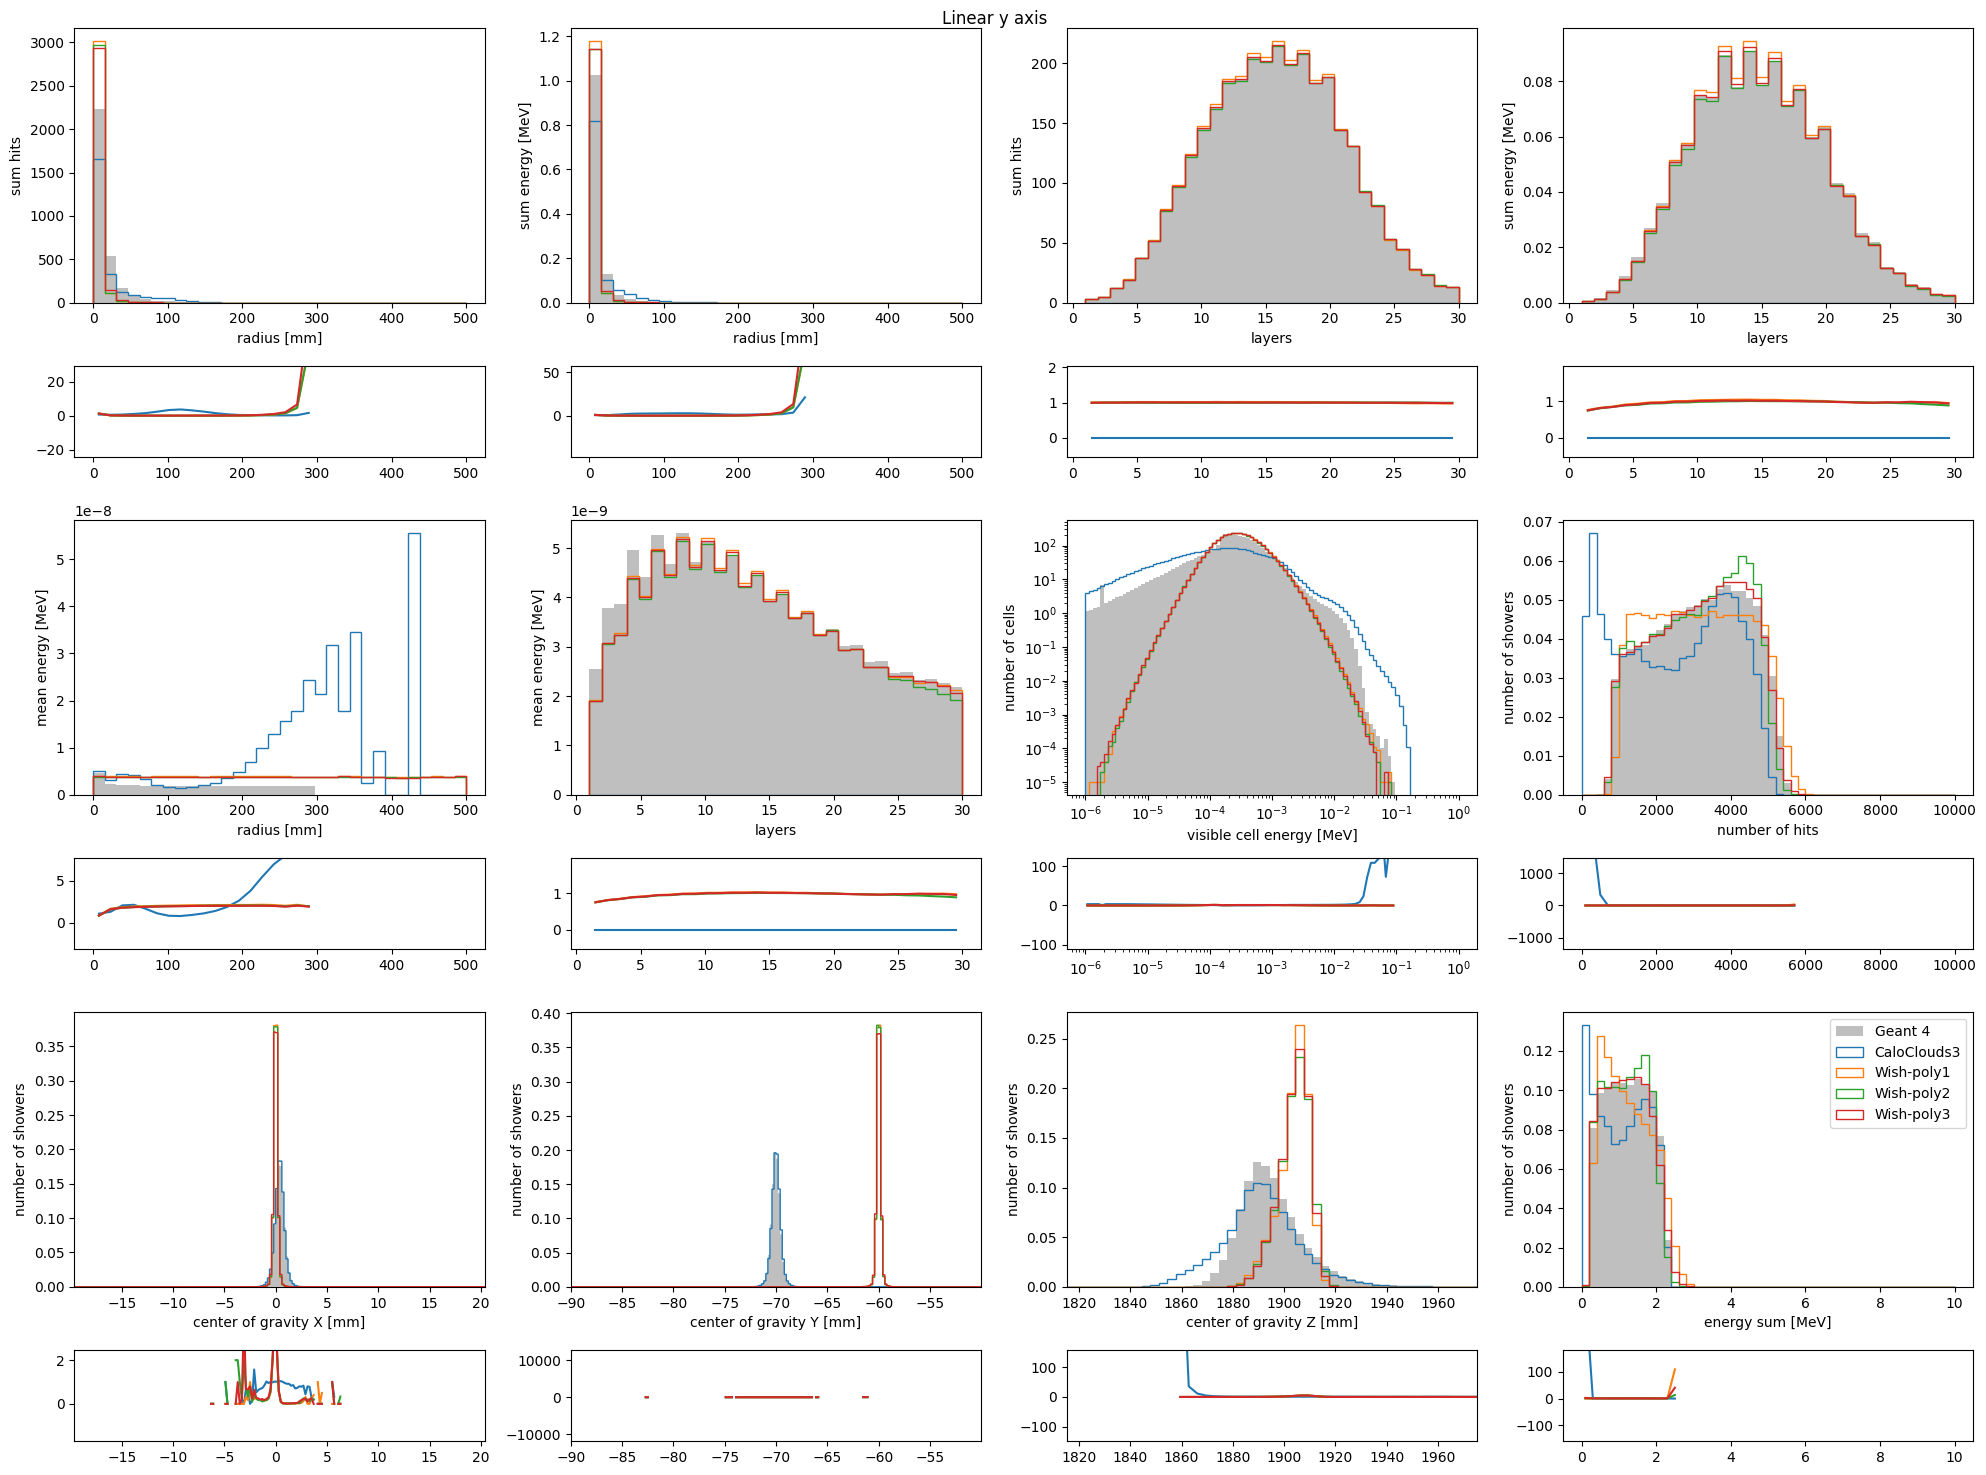

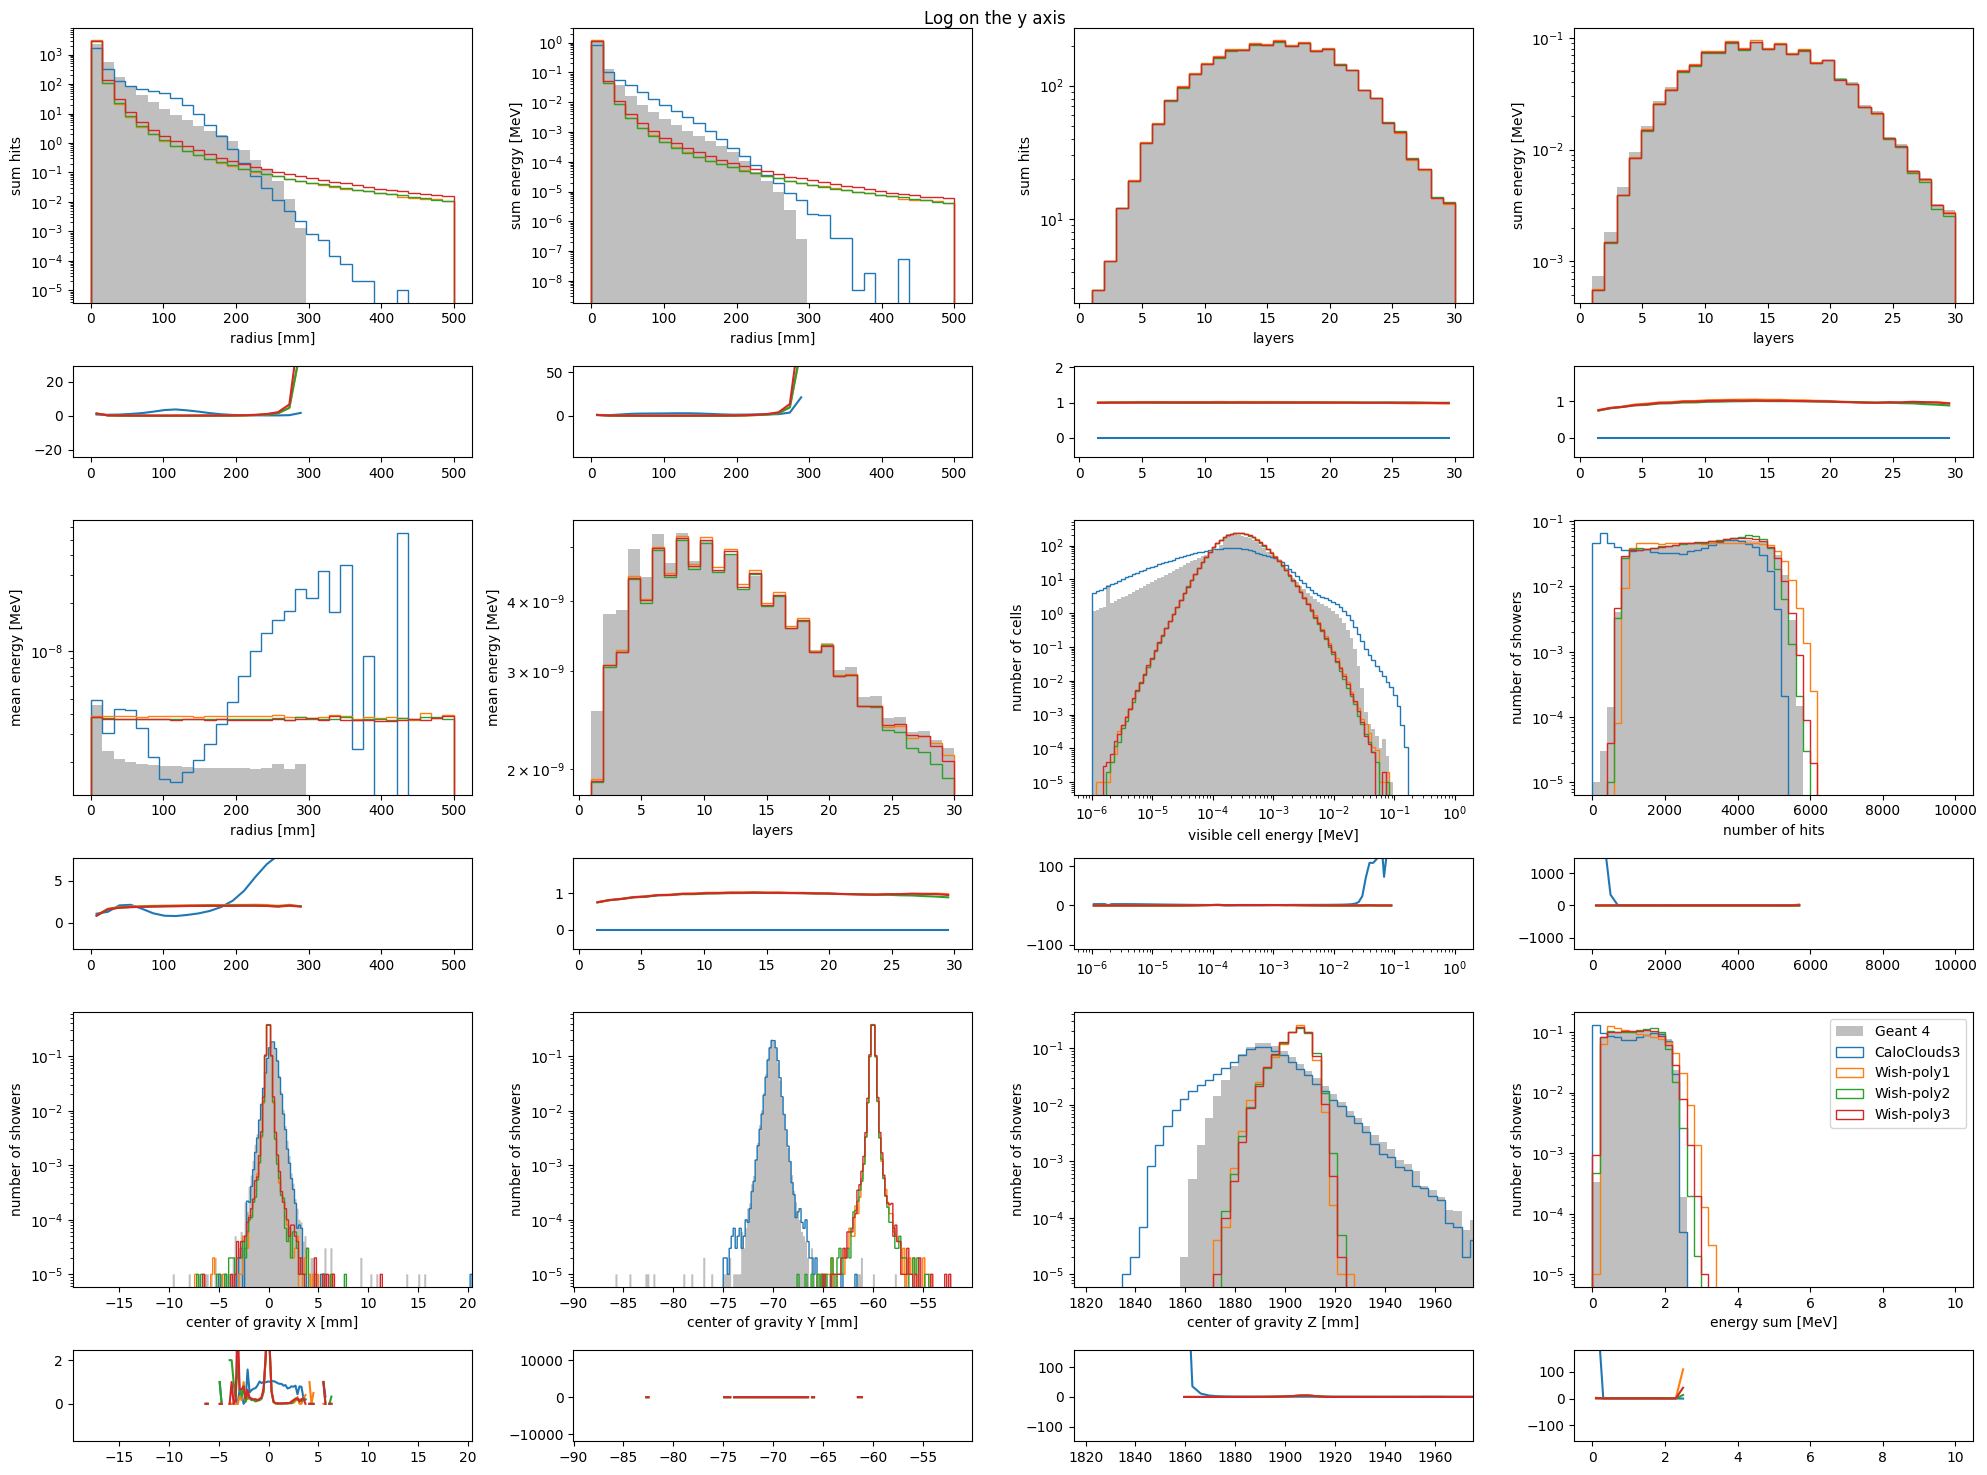

In [5]:
hist_idx_order = [0, 10, 7, 1, 11, 9, 2, 4, 8, 3, 5, 6]

n_plts = len(hist_idx_order)
n_rows = int(n_plts/4)
height_ratios = [3, 1]*n_rows

for semilogy in [False, True]:
        
    fig, ax_arr = plt.subplots(2*n_rows, 4, figsize=(20,5*n_rows), gridspec_kw={'height_ratios':height_ratios})
    ax_arr = ax_arr.T.flatten()
    
    if semilogy:
        fig.suptitle("Log on the y axis")
    else:
        fig.suptitle("Linear y axis")
    
    model_colours = [plt.cm.tab10(i/10) for i in range(len(to_compare))]
    
    for i, hist_idx in enumerate(hist_idx_order):
        
        main_ax = ax_arr[2*i]
        ratio_ax = ax_arr[2*i+1]
        ratio_ax.sharex(main_ax)
        
        x_label = binned_g4.x_labels[hist_idx]
        main_ax.set_xlabel(x_label)
        main_ax.set_ylabel(binned_g4.y_labels[hist_idx])
        if semilogy:
            main_ax.semilogy()
        
        # G4
        dummy_values = binned_g4.dummy_xs(hist_idx)
        #weights = binned_g4.counts[hist_idx]
        weights = binned_g4.normed(hist_idx)
        bins = binned_g4.bins[hist_idx]
        main_ax.hist(dummy_values, bins=bins, weights=weights, label=binned_g4.name,
                     histtype="stepfilled", color="grey", alpha=0.5)
    
        
        # Fix some axes
        if "center of gravity" in x_label:
            center_pos = np.nansum(dummy_values*weights)/np.nansum(weights)
            if "Z" in x_label:
                half_width = 80
            else:
                half_width = 20
            try:
                main_ax.set_xlim(center_pos-half_width, center_pos+half_width)
            except ValueError as e:
                print(f"{x_label}, {center_pos}")
                print(e)
        if "visible cell energy" in x_label:
            main_ax.loglog()
            
            
        # Acc
        ratios = []
        if hist_idx in [0, 1, 2, 3, 10, 11] and binned_acc is not None:
            #acc_weights = binned_acc.counts[hist_idx]
            acc_weights = binned_acc.normed(hist_idx)
            main_ax.hist(dummy_values, bins=bins, weights=acc_weights,
                         label=binned_acc.name, histtype="step", color='k', lw=3)
            acc_ratio = acc_weights/weights
            ratio_ax.plot(dummy_values, acc_ratio, c='k', label=binned_acc.name, lw=3)
            ratios.append(acc_ratio)
        
        # models
        for colour, model_name in zip(model_colours, to_compare):
            model = to_compare[model_name]
            # bins and dummys should be the same
            #model_weights = model.counts[hist_idx]
            model_weights = model.normed(hist_idx)
            
            main_ax.hist(dummy_values, bins=bins, weights=model_weights, label=model.name,
                         histtype="step", color=colour)
            
            # and the ratio
            ratio = model_weights/weights
            ratio_ax.plot(dummy_values, ratio, c=colour, label=model.name)
            ratios.append(ratio)
        
            
        all_ratios = np.concatenate(ratios)
        all_ratios = all_ratios[np.isfinite(all_ratios)]
        mean_ratio = np.nanmean(all_ratios)
        std_ratio = np.nanstd(all_ratios)
        ratio_ax.set_ylim(mean_ratio - 3*std_ratio, mean_ratio + 3*std_ratio)
    
    main_ax.legend()
    
    fig.tight_layout()
    

In [7]:
save_path

'/home/henry/training/point-cloud-diffusion-logs/wish/binned_metrics/Wish-poly3.npz'